In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt

### Create pal

In [2]:
gamma = 0.8
m16RGB = np.array([[[255,0,0],
                    [255,102,0],
                    [255,204,0],
                    [204,255,0],
                    [102,255,0],
                    [0,255,0],
                    [0,255,102],
                    [0,255,204],   
                    [0,204,255],
                    [0,102,255],
                    [0,0,255],
                    [102,0,255],
                    [204,0,255],
                    [255,0,204],
                    [255,0,102],
                    [127,127,127]]])

In [3]:
m16HSV=skimage.color.rgb2hsv(m16RGB/255.0)

In [4]:
HSV256 = np.rot90(np.repeat(m16HSV,16,axis=0))

In [5]:
RGB256 = skimage.color.hsv2rgb(HSV256)


In [6]:
LAB256 = skimage.color.rgb2lab(RGB256)

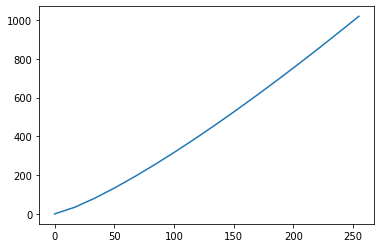

In [7]:
gamma = 0.8
x=np.linspace(0,255,16)
y=np.power(x,1.0/gamma)
plt.plot(x,y)
new_y = (y/y.max())*100

In [8]:
for i in range(16):
    LAB256[:,i,0]=new_y.astype(np.uint32)[i]

In [9]:
RGB256 = skimage.color.lab2rgb(LAB256)

C:\Anaconda3\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 43 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


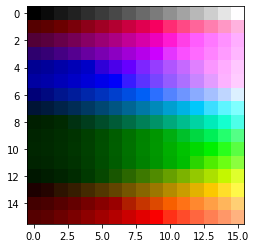

In [10]:
plt.imshow(RGB256)

In [11]:
pal=(RGB256.flatten()*255).astype(np.uint32)

In [12]:
#save as pal format
fileName = "out.pal"
with open(fileName,'w') as outFile:
    outFile.write("JASC-PAL\n")
    outFile.write("0100\n")
    outFile.write("256\n")
    for i in range(256):
        outFile.write("%d %d %d\n"%(pal[i*3],pal[i*3 +1],pal[i*3+2]))

In [30]:
#save as c format
fileName = "pal.c"
palName = 'default_pal'
with open(fileName,'w') as outFile:
    outFile.write("#include \"B3L_types.h\"\n")
    outFile.write("u32 "+palName+"[256]={\n")
    for i in range(16):
        buf=""
        for j in range(16):
            r= pal[i*16*3+j*3]
            g= pal[i*16*3+j*3+1]
            b= pal[i*16*3+j*3+2]
            index = i*16+j
            color = r|(g<<8)|(b<<16)|(index<<24)
            buf +="0x%08X, "%color
            if j==7:
                buf+='\n'
        buf +='\n'
        outFile.write(buf)
    outFile.write("};\n")

### Process Image

In [13]:
from PIL import Image

In [14]:
def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)




In [15]:
oldimage=Image.open('body.bmp')

In [16]:
palimage = Image.new('P',(16,16))
palimage.putpalette(list(pal))
#newimage=oldimage.quantize(palette=palimage)
newimage = quantizetopalette(oldimage, palimage, dither=False)
newimage.show()

In [17]:
imgarr = np.array(newimage)


In [18]:
#image should be square and <256 pixel
if (imgarr.shape[0]!=imgarr.shape[1]):
    size = min(min(imgarr.shape[0],imgarr.shape[0]),256)
    imgarr = imgarr[0:size,0:size]
print(imgarr.shape)

(256, 256)


In [19]:
fileName = "body2.c"
dataName = 'body_tex'
ID = 0x00123123
length = imgarr.shape[0]*imgarr.shape[0] + 6
with open(fileName,'w') as outFile:
    outFile.write("#include \"B3L_types.h\"\n")
    outFile.write("#pragma pack(4)\n")
    outFile.write("u8 "+dataName+"[%d]={\n"%(length))
    ID0 = ID&0xff
    ID1 = (ID>>8)&0xff
    ID2 = (ID>>16)&0xff
    ID3 = ID>>24
    sizeHigh = (imgarr.shape[0]>>8)
    sizeLow =  (imgarr.shape[0]&0xff)
    outFile.write("0x%02X, 0x%02X, 0x%02X, 0x%02X, 0x%02X, 0x%02X,\n"%(ID0,ID1,ID2,ID3,sizeLow,sizeHigh))
    for i in range(imgarr.shape[0]):
        buf=""
        line = imgarr[i,:]
        for j in range(imgarr.shape[0]):

            idx = line[j]
            #print(idx)
            if (idx == 0):
                idx= 1
            buf +="0x%02X, "%idx
            if ((j+1)%16==0):
                buf+='\n'
        buf +='\n'
        outFile.write(buf)
    outFile.write("};\n")  